# Simulated Annealing Demo

Skrypt przedstawia przykładową implementację algorytmu symulowanego wyżarzania (ang. Simulated Annealing, SA) i jego zastosowanie do rozwiązywania problemu Quadratic Assignment Problem (QAP). Problem jest dokładnie opisany m.in. w pracy Burkarda i innych [1]. Popularne instancje problemu QAP można znaleźć w bibliotece QAPLib [2]. Skrypt skupia się na rozwiązywaniu instancji NUG12 [3], w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu.

Literatura:

[1]  Burkard, R., Cela, E., Pardalos, P., Pitsoulis, L., "The Quadratic Assignment Problem", http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.217.1914

[2] QAPLIB, http://anjos.mgi.polymtl.ca/qaplib/

[3] NUG12, http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request

%matplotlib inline

In [2]:
nug = 12
QAP_INSTANCE_URL = lambda x: f'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug{x}.dat'

## Reading input data

In [3]:
def get_data(nug):
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL(nug))

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)
    return A, B

A, B = get_data(nug)

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

## Objective function

In [4]:
def qap_objective_function(p, A, B, n):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [5]:
p = [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]
print(qap_objective_function(p, A, B, nug), p)

578.0 [11, 6, 8, 2, 3, 7, 10, 0, 4, 5, 9, 1]


## Random Sampling

In [11]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, nug), dtype=np.int64)
rand_costs = np.zeros(T)
for i in range(T):
    if i%10000 == 0:
        print(i)
    permutations[i, :] = np.random.permutation(nug)
    rand_costs[i] = qap_objective_function(permutations[i, :], A, B, nug)

print(time.time() - t0)

p = permutations[rand_costs.argmin(), :]
print(qap_objective_function(p, A, B, nug), p)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
175.89068961143494
590.0 [ 4  5  9  1  3  7  6  0 11 10  8  2]


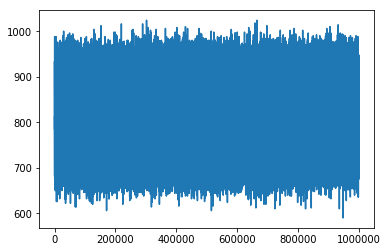

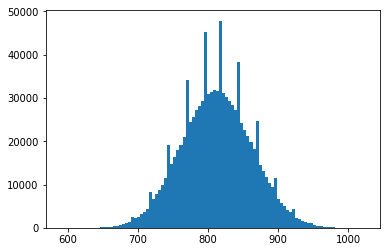

812.02107 49.69280173279726


In [12]:
plt.figure()
plt.plot(rand_costs)
plt.show()
plt.figure()
plt.hist(rand_costs, bins=100)
plt.show()

print(rand_costs.mean(), rand_costs.std())

## Simulated Annealing

In [13]:
def random_neighbor(p, radius, n):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

def sa(T, radius, alpha, A, B, n):
    p = np.random.permutation(n)
    p_cost = qap_objective_function(p, A, B, n)
    costs = np.zeros(T)
    for t in range(T):
        if t%10000 == 0:
            print(t)
        q = random_neighbor(p, radius, n)
        q_cost = qap_objective_function(q, A, B, n)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    return costs

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
131.20671033859253 578.0


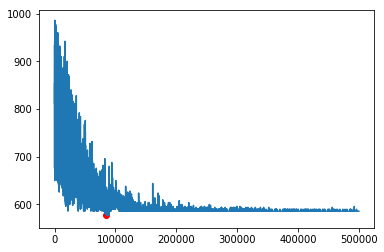

In [14]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()
costs = sa(T, radius, alpha, A, B, nug)

print(time.time() - t0, costs.min())
plt.figure()
plt.plot(costs)
plt.scatter([np.argmin(costs)], [np.min(costs)], c='red')
plt.show()

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

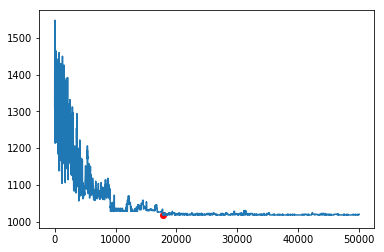

In [15]:
nug = 14
A, B = get_data(nug)

T = 50000
radius = 1
alpha = 1.0


t0 = time.time()
costs = sa(T, radius, alpha, A, B, nug)

print(time.time() - t0, costs.min())

plt.figure()
plt.plot(costs)
plt.scatter([np.argmin(costs)], [np.min(costs)], c='red')
plt.show()

Problem size: 16
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0.]]
Distance matrix:
 [[ 0.  0.  5.  0.  5.  2. 10.  3.  1.  5.  5.  5.  0.  0.  5.  4.]
 [ 0.  0.  3. 10.  5.  1.  5.  1.  2.  4.  2.  5.  0. 10. 10.  3.]


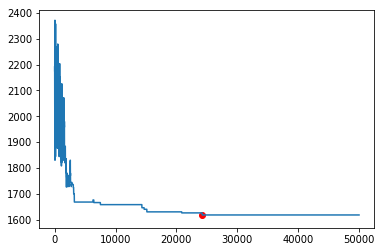

In [16]:
nug = 16
A, B = get_data("16a")

T = 50000
radius = 2
alpha = 1.5


t0 = time.time()
costs = sa(T, radius, alpha, A, B, nug)

print(time.time() - t0, costs.min())

plt.figure()
plt.plot(costs)
plt.scatter([np.argmin(costs)], [np.min(costs)], c='red')
plt.show()

Problem size: 16
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5. 3. 4. 5. 6.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4. 4. 3. 4. 5.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3. 5. 4. 3. 4.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2. 6. 5. 4. 3.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [3. 4. 5. 6. 2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [4. 3. 4. 5. 3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [5. 4. 3. 4. 4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [6. 5. 4. 3. 5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  0.  5.  0.  2. 10.  3.  1.  5.  5.  0.  0.  4.  4.  0.  0.]
 [ 0.  0.  3. 10.  1.  5.  1.  2.  2.  5.  0. 10.  3.  0.  5. 10.]


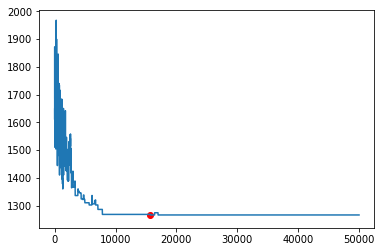

In [17]:
nug = 16
A, B = get_data("16b")

T = 50000
radius = 2
alpha = 1.5


t0 = time.time()
costs = sa(T, radius, alpha, A, B, nug)

print(time.time() - t0, costs.min())

plt.figure()
plt.plot(costs)
plt.scatter([np.argmin(costs)], [np.min(costs)], c='red')
plt.show()

Problem size: 17
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1.]
 [4. 3. 4. 5. 6. 3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0.]]
Distance matrix:
 [[ 0.  0.  5.  0.  5.  2. 10.  3

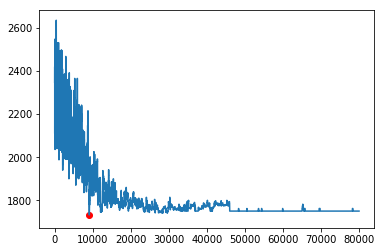

In [18]:
nug = 17
A, B = get_data(nug)

T = 80000
radius = 1
alpha = 0.5


t0 = time.time()
costs = sa(T, radius, alpha, A, B, nug)

print(time.time() - t0, costs.min())

plt.figure()
plt.plot(costs)
plt.scatter([np.argmin(costs)], [np.min(costs)], c='red')
plt.show()